**RNN**

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)


# Ensure data has business day frequency
data = data.asfreq('b')

# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')
data_vals = data.values
data_dates = data.index


/tmp/ipykernel_1593/2155313303.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


**Create models and results**

In [17]:
# Define the scheduler function
def step_decay(epoch):
    initial_lr = 0.01 # initial lr=[0.1, 0.01, 0.001]
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Normalize the data (apply MinMaxScaler across all features)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_vals)

# Define sequence length and lag (the number of days to predict forward based on sequence length)
sequence_length = 100
lags = [1,5,10,20,30] # Prediction horizons. Use 1 value for one model creation and evaluation
y_tests = []
preds = []
rmses = []

for lag in lags:
  # Prepare input (X) and output (Y) sequences
  X, Y = [], []
  for i in range(len(data_normalized) - sequence_length-lag):
      X.append(data_normalized[i:i + sequence_length])  # Input: sequence_length x num_features
      Y.append(data_normalized[i + sequence_length + lag, 3])    # Output (Using close at index 3)

  X = np.array(X)
  Y = np.array(Y)


  # Split the data into training and testing sets
  split_ratio = 0.8
  split_index = int(split_ratio * len(X))
  X_train, X_test = X[:split_index], X[split_index:]
  Y_train, Y_test = Y[:split_index], Y[split_index:]

  # Create the callback
  lr_scheduler = LearningRateScheduler(step_decay)

  # Build the RNN model for multivariate input and univariate output
  model = Sequential([
        SimpleRNN(units=80, return_sequences=False, input_shape=(sequence_length, X.shape[2])),
        Dense(units=1)
    ])


  model.summary()
  plot_model(model, to_file="simple_rnn_model.png", show_shapes=True, show_layer_names=True)
  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(X_train, Y_train, epochs=50, batch_size=64, verbose=1, callbacks=[lr_scheduler]) # batch size=[32, 64, 128]

  # Predict on the test set
  predictions = model.predict(X_test)

  # Inverse scale predictions and actual values for evaluation
  min_val = scaler.data_min_[3]  # Minimum value of feature 3
  max_val = scaler.data_max_[3]  # Maximum value of feature 3

  # Denormalize the predictions
  predictions_rescaled = predictions * (max_val - min_val) + min_val
  Y_test_rescaled = Y_test * (max_val - min_val) + min_val

  # Evaluate the model using Root Mean Squared Error (RMSE) for the fourth variable 'Close'
  rmse = np.sqrt(mean_squared_error(Y_test_rescaled, predictions_rescaled))
  print(f"Root Mean Squared Error: {rmse}")


  y_tests.append(Y_test_rescaled)
  preds.append(predictions_rescaled)
  rmses.append(rmse)

/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 80)             │         6,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.7113 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0358 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0183 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0106 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0045 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.9613e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.3938e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.2771e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.2638e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0139e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.0480e-04 - learni

/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, 80)             │         6,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.3546 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.3110 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0215 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0174 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0147 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0111 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0074 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0034 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.6280e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.9060e-04 - learning_rate: 0.0050


/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 80)             │         6,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1585 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0204 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0113 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0023 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.4532e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.3063e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.8939e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 5.1513e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.5630e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 4.7865e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 5.3228e-04 - le

/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 80)             │         6,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3398 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2709 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0167 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0108 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0046 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.5383e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.2546e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.1631e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 8.2155e-04 - learning_rate:

/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 80)             │         6,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.3071 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0075 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0014 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0013 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0014 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - learning_rate: 0.0050
Epoch 12

**Plot**

Predictions 1 days forward rmse: 65.08036802001315
Predictions 5 days forward rmse: 127.69338708920122
Predictions 10 days forward rmse: 54.01577307143586
Predictions 20 days forward rmse: 143.15751427643357
Predictions 30 days forward rmse: 55.66067427645206


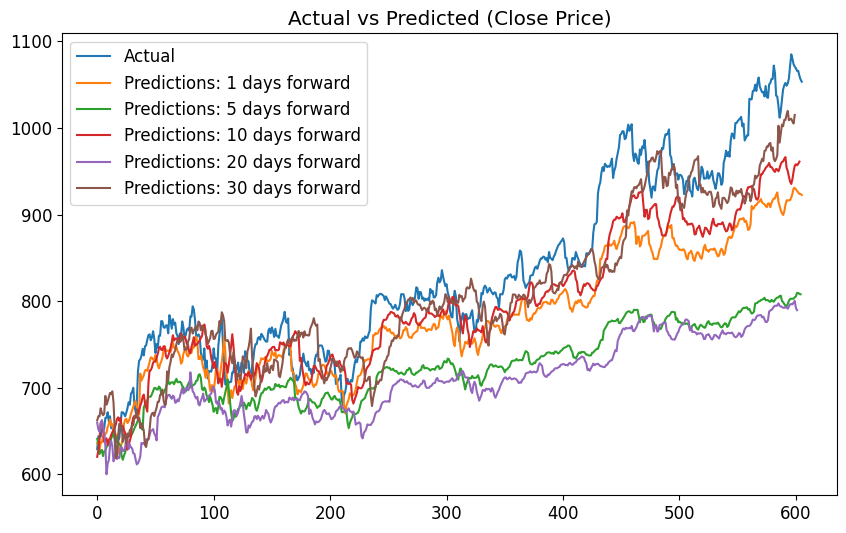

In [18]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(y_tests[0], label='Actual')

for i in range(len(preds)):
  plt.plot(preds[i], label='Predictions: '+ str(lags[i]) + ' days forward')
  print('Predictions ' + str(lags[i]) + ' days forward rmse: ' + str(rmses[i]))

plt.legend()
plt.title("Actual vs Predicted (Close Price)")
plt.savefig("RNN_preds.png")
plt.show()


Predictions 30 days forward rmse: 55.66067427645206


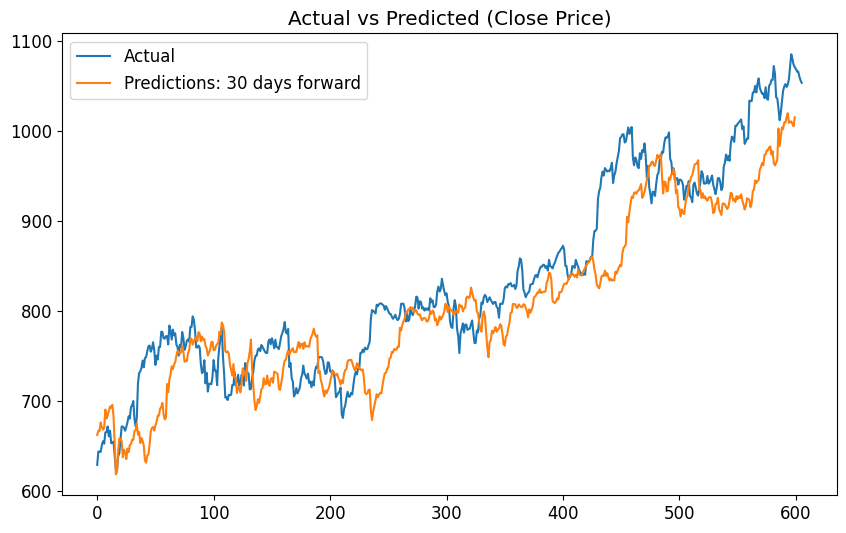

In [19]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(y_tests[0], label='Actual')

plt.plot(preds[4], label='Predictions: '+ str(lags[4]) + ' days forward')
print('Predictions ' + str(lags[4]) + ' days forward rmse: ' + str(rmses[4]))

plt.legend()
plt.title("Actual vs Predicted (Close Price)")
plt.savefig("RNN_optimitazion_2.png")
plt.show()


In [20]:
split_index-len(y_tests[0])

1793

In [21]:
len(y_tests[0])

606